Project 5 - Vehicle Detection - Report. Vilas Chitrakaran. March 2017

# Executive Summary
The objective is to develop a software pipeline to identify and track vehicles in a video stream obtained from a front-facing camera mounted on the dashboard of a car. A linear support vector machine (SVM) is trained to identify vehicles based on histogram-of-oriented-gradients (HOG) features extracted from 'car' and 'non-car' image sets. The trained SVM is then applied on the video stream to search and identify vehicles. The robustness of the identification pipeline is improved by temporal filtering techniques to discard false positives. 

The following video demonstrates the final result obtained from my implementation.

[Demo Video](https://youtu.be/XJeOtTjelb4)

In [23]:
#=====================================================================
# Demo video of vehicle detection using pipeline described in this report
import IPython
vid = IPython.display.YouTubeVideo("XJeOtTjelb4")
IPython.display.display(vid)

# Processing Pipeline Development

The vehicle is instrumented with a front-facing video camera that provides an RGB video stream of the road ahead. A processing pipeline is designed to search for vehicles from frame to frame within this video stream. Briefly, we sweep a sliding window across the image frame, and using a trained support vector machine (SVM), determine whether a vehicle is present within a particular window or not. SVM is a robust binary classifier, and the first step, therefore, is to train it. In order to do this, we were provided with a labeled image dataset containing vehicle and non-vehicle examples from the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself. Unlike convolutional neural networks (CNNs), SVMs do not accept images directly as input but rather 'features' that are extracted from those images. We start by organising the dataset provided to us, followed by feature extraction.

__Note__: In the code snippets below, you will notice that I routinely delete data structures once I am done with them. This is because of limited resources on the laptop on which I implemented this project. I was running out of memory too soon and unable to go past training stage unless I clawed back main memory, especially after training the SVM. 

Number of car images in the dataset: 8792
Number of non-car images in the dataset: 8968


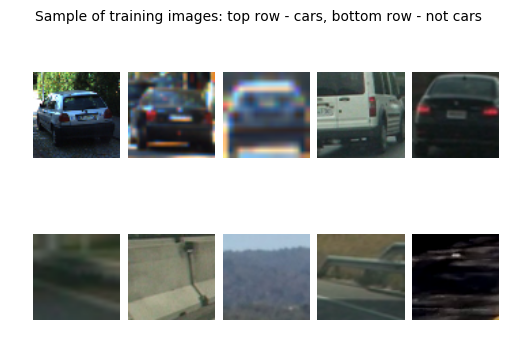

In [2]:
#=====================================================================
# Prepare list of image files used for training

import gc
import glob
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Utility function to read an image in RGB color-space
def read_image(filename):
    image = cv2.imread(filename)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Make a list of training images we were given
trainingImages = glob.glob('./training_set/**/*.png', recursive=True)
carImageNames = []
notCarImageNames = []

# I have already organised them into 'vehicle' and 'non-vehicle' sub-directories. Use the 
# directory structure to generate a list of vehicle and non-vehicle images
for filename in trainingImages:
    if 'non-vehicles' in filename:
        notCarImageNames.append(filename)
    else:
        carImageNames.append(filename)

print('Number of car images in the dataset:', len(carImageNames))
print('Number of non-car images in the dataset:', len(notCarImageNames))

# Select a random set of car and non-car images and show it
fig,ax = plt.subplots(2,5)
fig.suptitle('Sample of training images: top row - cars, bottom row - not cars')
for i in range(5):
    ax[0,i].imshow(read_image(carImageNames[np.random.randint(0, len(carImageNames))]))
    ax[0,i].axis('off')
    
    ax[1,i].imshow(read_image(notCarImageNames[np.random.randint(0, len(notCarImageNames))]))
    ax[1,i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Feature Extraction

We now have an organised list of training data. The next step is to define and extract a feature vector from each of these images. We use [histogram-of-oriented-gradients (HOG)](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) as the primary feature by which to differentiate between vehicles and everything else. HOG features, roughly speaking, encode the shape of objects within an image and the 'signature' thus obtained is robust to variations in perceived shape due to small changes in relative position and orientation. HOG features are, however, invariant to color. Since vehicles typically are brightly colored things, augmenting the HOG feature vector with raw pixel values and colour histogram of the image patch improves the quality of the feature vector in terms of it's ability to distinguish between vehicle and background. Therefore, the feature vector that we use is composed of spatially binned pixel values, colour histogram and HOG of the image patch.

The color-space of the input images matter. Working through the exercises in this lesson, I found that color-spaces such as HSV and YCrCb provide better selectivity than RGB. I eventually settled on YCrCb as they seemed to result in fewer false positives in the project video. Similarly, the following set of parameters were chosen for extracting HOG and spatial features:

* HOG feature extraction parameters
    - Number of orientations = 9
    - Pixels per cell = 8
    - Cells per block = 2
    - Feature are extracted on all channels of the image 

* Spatial feature extraction parameters
    - Length: 16 x 16 x 3
    
* Histogram feature extraction parameters
    - Length: 16 x 3
    - Range of values: 0 - 255
    
__Note__: Unlike my previous project submissions, I have chosen to hard-code my choice of parameters in the following code snippets. The rationale being changing one parameter effects the choice of all others; therefore, it's best to choose a set that works and stick with it for the given project video. Most of the parameters were chosen by trial and error on code exercises accompanying this lesson.

Feature vector length: 6108


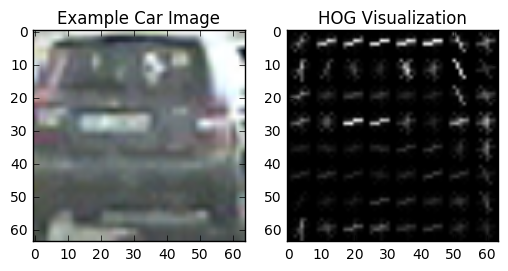

In [3]:
#=====================================================================
# Feature extraction

from skimage.feature import hog
   
# Wrapper to apply a chosen color conversion to an RGB image
def convert_color(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

# Generate spatial feature vector
def get_spatial_features(image):
    size = 16 
    return cv2.resize(image, (size, size)).ravel()

# Generate histogram feature vector
def get_histogram_features(image):
    numBins=16
    binsRange=(0, 256)
    features = []
    for channel in range(image.shape[2]):
        ch = np.histogram(image[:,:,channel], bins=numBins, range=binsRange)
        features.append(ch[0])
    return np.concatenate(features)


# Given an image, generate HOG feature vector for the image with the following chosen parameters
# 9 orientation, 8x8 pixels per cell, 2x2 cells per block
# image - single channel image
# bVisual - If True, also return an image of the HOG
# bFeatVec - If True, return the data as a feature vector by calling .ravel() on the result just before returning.
def get_hog_features(image, bVisual=False, bFeatVec=True):
    # if bVisual == True, return features, hog_image, else just return features
    return hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
               transform_sqrt=False, visualise=bVisual, feature_vector=bFeatVec)

# Create a feature vector for an image. The image must be RGB and all channels of the image are used
def extract_features(image):
    featureImage = convert_color(image) # apply color conversion
    spatialFeatures = get_spatial_features(featureImage)
    histFeatures = get_histogram_features(featureImage)
    hogFeatures = [] # get HOG features for all channels
    for channel in range(featureImage.shape[2]):
        hogFeatures.append(get_hog_features(featureImage[:,:,channel], bVisual=False, bFeatVec=True))
    hogFeatures = np.ravel(hogFeatures)
    return np.concatenate((spatialFeatures, histFeatures, hogFeatures))

# Create an array of feature vectors given a list of image file names
def extract_features_from_files(imageFileNames):
    features = [] # Create a list to append feature vectors to
    for file in imageFileNames: # Iterate through the list of images
        image = read_image(file)        
        features.append(extract_features(image))
    return features # Return list of feature vectors

# Test feature extractor on a single channel image
index = np.random.randint(0, len(carImageNames))
image = read_image(carImageNames[index])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hogFeatures, hogImage = get_hog_features(gray, bVisual=True, bFeatVec=False)
features = extract_features(image)
print('Feature vector length:',len(features))

fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example car image')
plt.subplot(122)
plt.imshow(hogImage, cmap='gray')
plt.title('HOG visualization')
plt.show()

# free up variables after use. I have limited resources on my machine
del features, hogFeatures, hogImage, image, gray
gc.collect();

## Classifier Training

Now that a feature vector has been defined, the next step is to create the training data set in the form of a stack of features extracted from training images and corresponding binary labels (1='vehicle', 0='no-vehicle). The data set is then shuffled and randomly split into two sets, one of which is used to train the classifier and the other is used as a test set to verify the performance of the classifier.

Since a feature vector is composed of multiple features of different types, they are normalised before use in order to ensure that they all are equally weighted in their contribution to the classification of an image.

__Note__: Since the image dataset is extracted from video streams, the training images must be shuffled in order to avoid feeding the classifier with sequences of images that are almost identical.

88.89 Seconds to extract features from 14000 training samples.


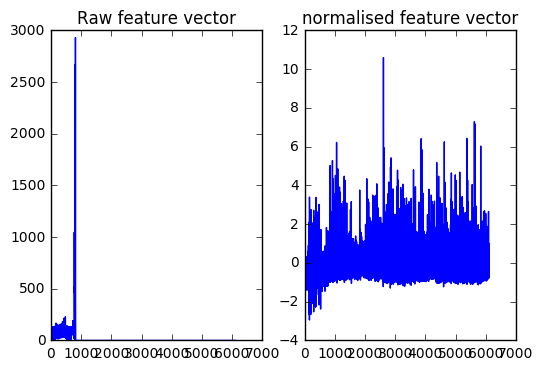

Number of images in the training set: 11200
Number of images in the test set: 2800


In [4]:
#=====================================================================
# Classifier training - prepare training and test datasets

import time
import random
import sklearn
from sklearn.preprocessing import StandardScaler

# need scikit-learn version to determine how to import train_test_split
(skl_major, skl_minor, _) = sklearn.__version__.split(".")

if int(skl_major) == 0 and int(skl_minor) <= 17:
    from sklearn.cross_validation import train_test_split
if int(skl_major) == 0 and int(skl_minor) > 17:
    from sklearn.model_selection import train_test_split

# Pick a random subset of training images to train the classifier on
# Use a subset and not all of it due to computational constraints I have on my laptop.
sampleSize = 7000
carImageNamesSet = random.sample(carImageNames, sampleSize)
notCarImageNamesSet = random.sample(notCarImageNames, sampleSize)

# Extract feature vectors from training images
t=time.time()
carFeatures = extract_features_from_files(carImageNamesSet)
notCarFeatures = extract_features_from_files(notCarImageNamesSet)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features from', len(carFeatures)+len(notCarFeatures), 'training samples.')

# Create a stack of feature vectors and normalise them
featureStack = np.vstack((carFeatures, notCarFeatures)).astype(np.float64)                        
featureScaler = StandardScaler().fit(featureStack) # Fit a per-column scaler
scaledFeatureStack = featureScaler.transform(featureStack) # Apply the scaler

# Define the corresponding labels vector
labelStack = np.hstack((np.ones(len(carFeatures)), np.zeros(len(notCarFeatures))))

# plot a randomly selected feature vector
indx = np.random.randint(0, len(featureStack))
fig = plt.figure()
plt.subplot(121)
plt.plot(featureStack[indx])
plt.title('Raw feature vector')
plt.subplot(122)
plt.plot(scaledFeatureStack[indx])
plt.title('Normalised feature vector')
plt.show()

# Split up training data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaledFeatureStack, labelStack, 
                                                    test_size=0.2, random_state=rand_state)

print('Number of images in the training set:', len(X_train))
print('Number of images in the test set:', len(X_test))

# free up variables after use. I have limited resources on my machine
del trainingImages, carImageNames, notCarImageNames, carImageNamesSet, notCarImageNamesSet
del carFeatures, notCarFeatures, featureStack
del scaledFeatureStack, labelStack
gc.collect();

We now have training data in the form that we need for the SVM classifier. All that remains to be done is to train the classifier and test the accuracy of training. This is done in the following code section:

In [5]:
#=====================================================================
# Classifier training - do the training

from sklearn.svm import LinearSVC

# Create Linear Support Vector Machine and use it as the classifier 
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time 
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# free up variables after use. I have limited resources on my machine
del X_train, X_test, y_train, y_test
gc.collect();

1.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9911
My SVC predicts:  [ 0.  1.  1.  0.  0.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  1.  1.  0.  0.]
0.00168 Seconds to predict 10 labels with SVC


In order to avoid the time consuming process of generating feature vectors and training the classifier, pickle up the trained classifier and the scaler so that we can reuse it without revisiting the previous steps.

In [6]:
#=====================================================================
# Save trained classifier for later reuse

import pickle

pickleDict = {}
pickleDict["svc"] = svc
pickleDict["featureScaler"] = featureScaler

pickeFile = open("p5_classifier_pickle.p", "wb")
pickle.dump(pickleDict, pickeFile)
pickeFile.close()

## Vehicle Detection


Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?
Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

__NOTE__: on selection of number of scales to search - scale=0.5 caused a lot of false positives at perspectively far distances from the car as well as nearby. At far distances we don't care about other vehicles. We do care about false positives nearby as that will cause an unwanted avoidance action that may lead to accidents. Therefore, false positives must be eliminated in the near vicinity.


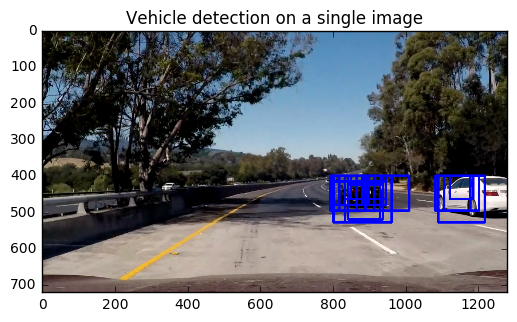

In [18]:
#=====================================================================
# Vehicle detection - sub-sampling window search

# Find vehicles in a sub-region of the image and return corresponding bounding boxes
def find_vehicles(image, ystart, ystop, scale, svc, X_scaler):
    
    # we will accumulate a list of potential vehicle locations here in the form [((x1, y1), (x2, y2)),...]
    bboxes = []
    
    # Take the specified ROI in the image and transform the color space
    subImage = image[ystart:ystop,:,:]
    colorTransImage = convert_color(subImage)
    
    # re-scale image to find vehicles at scale specified
    if scale != 1:
        imshape = colorTransImage.shape
        colorTransImage = cv2.resize(colorTransImage, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # break the image into channels
    ch1 = colorTransImage[:,:,0]
    ch2 = colorTransImage[:,:,1]
    ch3 = colorTransImage[:,:,2]

    # pre-defined constants
    pixelsPerCell = 8
    cellsPerBlock = 2
    numOrientations = 9
    
    # Define blocks and steps as above
    numBlocksX = (ch1.shape[1] // pixelsPerCell)-1
    numBlocksY = (ch1.shape[0] // pixelsPerCell)-1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    numBlocksPerWindow = (window // pixelsPerCell)-1
    
    cellsPerStep = 2  # define how many cells to step across as we slide the window
    numStepsX = (numBlocksX - numBlocksPerWindow) // cellsPerStep
    numStepsY = (numBlocksY - numBlocksPerWindow) // cellsPerStep
       
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, bFeatVec=False)
    hog2 = get_hog_features(ch2, bFeatVec=False)
    hog3 = get_hog_features(ch3, bFeatVec=False)
    
    # slide window across and calculate the feature vector as we go
    for xb in range(numStepsX):
        for yb in range(numStepsY):
            yPos = yb * cellsPerStep
            xPos = xb * cellsPerStep
            
            # Extract HOG for this patch
            hogFeatures1 = hog1[yPos:yPos+numBlocksPerWindow, xPos:xPos+numBlocksPerWindow].ravel() 
            hogFeatures2 = hog2[yPos:yPos+numBlocksPerWindow, xPos:xPos+numBlocksPerWindow].ravel() 
            hogFeatures3 = hog3[yPos:yPos+numBlocksPerWindow, xPos:xPos+numBlocksPerWindow].ravel() 
            hogFeatures = np.hstack((hogFeatures1, hogFeatures2, hogFeatures3))

            xLeft = xPos * pixelsPerCell
            yTop = yPos * pixelsPerCell

            # Extract the image patch
            patchImage = cv2.resize(colorTransImage[yTop:yTop+window, xLeft:xLeft+window], (64,64))
          
            # Get spatial and histogram color features
            spatialFeatures = get_spatial_features(patchImage)
            histogramFeatures = get_histogram_features(patchImage)

            # Scale features and make a prediction
            testFeatures = X_scaler.transform(
                np.hstack((spatialFeatures, histogramFeatures, hogFeatures)).reshape(1, -1))    
            testPrediction = svc.predict(testFeatures)
            
            # if we found a car, add the bounding box to the list
            if testPrediction == 1:
                xBoxLeft = np.int(xLeft * scale)
                yBoxTop = np.int(yTop * scale)
                winSize = np.int(window * scale)
                bbox = ((xBoxLeft, yBoxTop+ystart),(xBoxLeft+winSize,yBoxTop+winSize+ystart)) 
                bboxes.append(bbox)
                
    return bboxes

# Test it
image = read_image('./test_images/test5.jpg')
yStarts = [400, 400, 400]
yStops = [500,600,650]
scales = [1,1.5,2]
bboxes = []
for (yStart,yStop,scale) in zip(yStarts,yStops,scales):
    bboxes += find_vehicles(image, yStart, yStop, scale, svc, featureScaler)

imageDetections = np.copy(image)
for bbox in bboxes:
    cv2.rectangle(imageDetections, bbox[0], bbox[1], (0,0,255), 6)
plt.imshow(imageDetections)
plt.title('Vehicle detection on a single image')
plt.show()

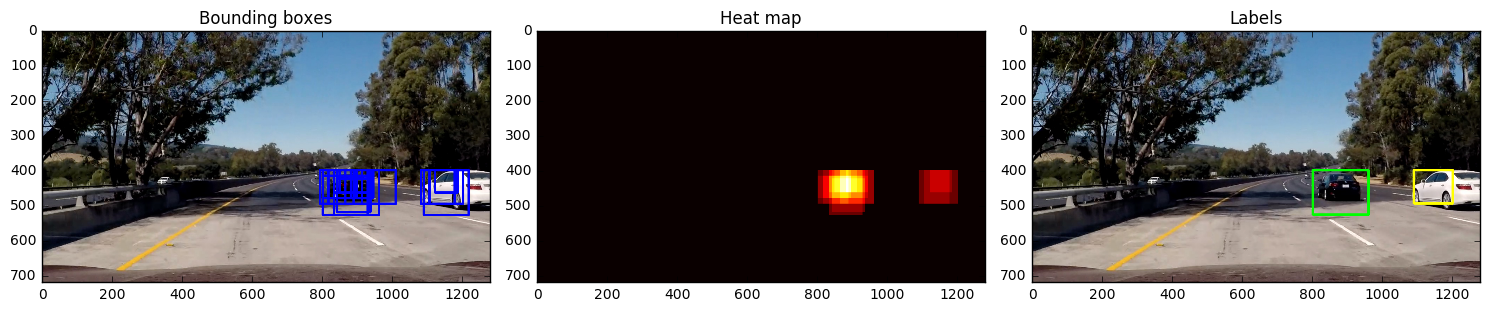

In [19]:
#=====================================================================
# Heatmap generation

from scipy.ndimage.measurements import label

# Create a heatmap given potentially overlapping bounding boxes
def create_heatmap(width, height, boundingBoxesList):
    heatImage = np.zeros((width,height)).astype(np.float)
    for box in boundingBoxesList:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatImage[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatImage

# Threshold the heatmap
def threshold_heatmap(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0 # Zero out pixels below the threshold
    return heatmap

def draw_labeled_bboxes(image, labels, colors):
    for carNumber in range(1, labels[1]+1):
        nonzero = (labels[0] == carNumber).nonzero() # Find pixels with each carNumber label value
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], colors[carNumber], 6)
    # Return the image
    return image

# Test above methods

# Create the heatmap
heatImage = create_heatmap(image.shape[0], image.shape[1], bboxes) # create heat image
heatImage = threshold_heatmap(heatImage,1) # Apply threshold to help remove false positives
heatImage = np.clip(heatImage, 0, 255) # Clip to visualizable limits

# Find final boxes from heatmap using label function
colors = [(255,0,0),(0,255,0),(255,255,0),(0,0,255),(255,0,255),(0,255,255)]
labels = label(heatImage)
labelledImage = draw_labeled_bboxes(np.copy(image), labels, colors)

fig = plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(imageDetections)
plt.title('Bounding boxes')
plt.subplot(132)
plt.imshow(heatImage, cmap='hot')
plt.title('Heat map')
plt.subplot(133)
plt.imshow(labelledImage)
plt.title('Labels')
fig.tight_layout()
plt.show()

# Processing Pipeline
Summarise the steps in the processing pipeline. 

Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Combine vehicle detection with lane detection

In [20]:
#=====================================================================
# Processing pipeline

# import project 4 for lane detection
from lane_detection import *

# A class to keep history of bounding boxes across frames
class BoundingBoxAccumulator:
    
    def __init__(self):
        self._list = []
        self._maxHist = 2
    
    def set_max_history(self,l):
        self._maxHist = l
    
    def get_max_history(self):
        return self._maxHist
    
    def add_boxes(self,bboxes):
        self._list.append(bboxes)
        if len(self._list) > self._maxHist:
            self._list.pop(0)
            
    def get_boxes(self):
        bb = []
        for item in self._list:
            bb += item
        return bb

# Vehicle detector class encapsulates the image processing pipeline 
class VehicleDetector:
    
    def __init__(self):
        self._prevBboxes = BoundingBoxAccumulator()
        self._prevBboxes.set_max_history(15)
        self._numFrames = 0
        self._maxNumVehicles = 0
        self._laneDetector = LaneDetector()
        self._laneDetector.set_debug(False)
        
        # Load the trained classifier and scaler
        pickleDict = pickle.load( open("p5_classifier_pickle.p", "rb" ) )
        self._svc = pickleDict["svc"]
        self._featureScaler = pickleDict["featureScaler"]
    
    def get_statistics(self):
        print('Number of frames processed:', self._numFrames)
        print('Maximum number of vehicles counted in a frame:', self._maxNumVehicles)
        
    def process_image(self,image):

        self._numFrames += 1

        # do lane detection
        lanesImage = self._laneDetector.process_image(image)
        
        # region of the image we will search for vehicles, and the scales we will search at
        yStart = 400
        yStops = [500,600,650]
        scales = [1,1.5,2]

        # find bounding boxes enclosing vehicles at all scales
        bboxes = []
        for scale,yStop in zip(scales,yStops):
            bboxes += find_vehicles(image, yStart, yStop, scale, self._svc, self._featureScaler)

        # add list of bounding boxes from previous image(or last n images)
        self._prevBboxes.add_boxes(bboxes)
        cumBboxes = self._prevBboxes.get_boxes()
        
        # generate heatmap for combined list of bounding boxes
        minDetections = self._prevBboxes.get_max_history() - 1 # Apply threshold to help remove false positives
        heatImage = create_heatmap(image.shape[0], image.shape[1], cumBboxes)        
        heatImage = threshold_heatmap(heatImage, minDetections)
        heatImage = np.clip(heatImage, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatImage)
        colors = [(127,127,127),(255,0,0),(0,255,0),(255,255,0),(0,0,255),(255,0,255),(0,255,255),(255,255,255)]
        labelledImage = draw_labeled_bboxes(lanesImage, labels, colors)
        if labels[1] > self._maxNumVehicles:
            self._maxNumVehicles = labels[1]
        
        return labelledImage

# Vehicle Detection - Project Video
All that remains now is to process the video sequence by applying the processing pipeline described in the previous section.

In [21]:
#=====================================================================
# process the project video

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# set input and output
output_video_name = 'output.mp4'
input_video = VideoFileClip("project_video.mp4")

# Create the vehicle detector
processor = VehicleDetector()
process_image = processor.process_image

# process video frame by frame
output_video = input_video.fl_image(process_image)
%time output_video.write_videofile(output_video_name, audio=False)

# print some stats
processor.get_statistics()

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4



100%|█████████▉| 1260/1261 [20:36<00:00,  1.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 1h 12min, sys: 1min 16s, total: 1h 13min 17s
Wall time: 20min 37s
Number of frames processed: 1261
Maximum number of vehicles counted in a frame: 5


# Discussion

Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

Removing false positives is really fiddly